# Investigating differences between styles by ingredient

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

from beerai.config import DATA_DIR

In [2]:
%matplotlib inline

In [3]:
with pd.HDFStore(os.path.join(DATA_DIR, "interim/all_recipes.h5")) as store:
    core = store.get("core")
    ings = store.get("ingredients")

In [4]:
core.head()

,batch_size,boil_size,boil_time,brewer,efficiency,name,origin,recipe_file,src_abv,src_color,src_fg,src_ibu,src_og,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,,,,,,,
0,18.927059,21.198306,60.0,velkyal,0.75,dark island oir leann,brewtoad,recipes/brewtoad/dark-island-oir-leann.xml,NaN,NaN,NaN,NaN,NaN,6b,bjcp,blonde ale,1.0
1,22.712471,28.390588,60.0,wain thor,0.85,witbur,brewtoad,recipes/brewtoad/witbur.xml,NaN,NaN,NaN,NaN,NaN,6d,bjcp,american wheat or rye beer,1.0
2,20.819765,24.983718,60.0,btfielder,0.75,kolsch,brewtoad,recipes/brewtoad/kolsch-9285a4.xml,NaN,NaN,NaN,NaN,NaN,6c,bjcp,kölsch,1.0
3,18.927059,23.658824,60.0,viff brewing,0.75,amber alert,brewtoad,recipes/brewtoad/amber-alert-4.xml,NaN,NaN,NaN,NaN,NaN,10b,bjcp,american amber ale,1.0
4,18.927059,23.658824,60.0,pistolpete2,0.75,graff,brewtoad,recipes/brewtoad/graff-14.xml,NaN,NaN,NaN,NaN,NaN,20a,bjcp,fruit beer,1.0


In [5]:
map_files = glob.glob(os.path.join(DATA_DIR, "interim/*map.pickle"))
map_files = {os.path.basename(m)[:-10]: m for m in map_files}

maps = {}
for label, map_file in map_files.items():
    with open(map_file, "rb") as f:
        maps[label] = pickle.load(f)

In [6]:
ings["ferm_name"] = ings["ferm_name"].map(maps["ferm"])
ings["hop_name"] = ings["hop_name"].map(maps["hop"])
ings["yeast_name"] = ings["yeast_name"].map(maps["yeast"])
ings["misc_name"] = ings["misc_name"].map(maps["misc"])

In [7]:
styles = ["robust porter", "american stout"]

In [8]:
recipe_ids = core[core["style_name"].isin(styles)].index

In [9]:
stouts =  core.loc[recipe_ids].join(ings, how="left")

In [10]:
stouts.index.nunique()

16895

There are a couple of ways we can frame the question of "how do the fermentables differ between 2 styles":

1. What is the difference in likelihood/probability (sorry statisticians) that an ingredient will appear in the average recipe for a style?
2. What is the difference in the amount of fermentable in the average recipe for a style?
3. Probably a few others, but 1 and 2 are the most interesting for now.

Let's start with 1.

## How likely is a the average recipe for a style to include a specific fermentable?

In [11]:
by_style_ferm = stouts.reset_index().groupby(["style_name", "ferm_name"])
prob_ferm_by_style = by_style_ferm["id"].nunique() / stouts.index.nunique()
prob_ferm_by_style

style_name      ferm_name               
american stout  2-row                       0.124179
                2-row brewers malt          0.061616
                2-row caramel malt 60l      0.046819
                6-row                       0.003019
                6-row brewers malt          0.004854
                                              ...   
robust porter   wheat malt extract syrup    0.001302
                wheat malt, white           0.014324
                wheat, flaked               0.004913
                wheat, red                  0.000237
                white wheat                 0.020835
Name: id, Length: 361, dtype: float64

In [12]:
compare = prob_ferm_by_style.unstack().T
compare["tot"] = compare.sum(axis=1)
compare["diff"] = compare["american stout"] - compare["robust porter"]
compare["absdiff"] = (compare["american stout"] - compare["robust porter"]).abs()
compare = compare.sort_values("absdiff", ascending=True)
compare

style_name,american stout,robust porter,tot,diff,absdiff
ferm_name,,,,,
"rice, flaked",0.000118,0.000118,0.000237,0.000000,0.000000
turbinado,0.001184,0.001184,0.002368,0.000000,0.000000
bavarian wheat lme,0.000355,0.000296,0.000651,0.000059,0.000059
flaked rice,0.000355,0.000296,0.000651,0.000059,0.000059
6-row,0.003019,0.002959,0.005978,0.000059,0.000059
...,...,...,...,...,...
flaked oats,0.086061,0.035277,0.121338,0.050784,0.050784
chocolate malt,0.120154,0.227405,0.347558,-0.107251,0.107251
black malt,0.123942,0.242557,0.366499,-0.118615,0.118615


Text(0.5, 0, 'Difference in probability')

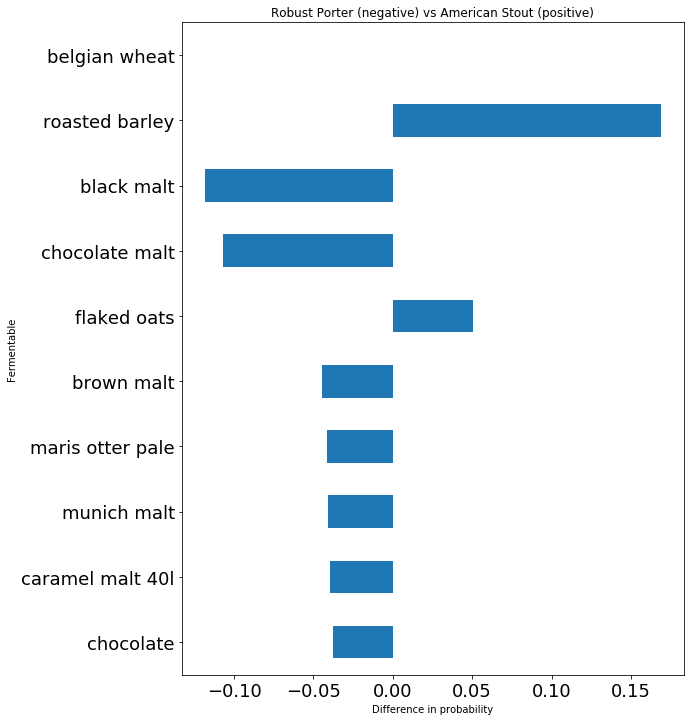

In [13]:
ax = compare.iloc[-10:, 3].plot(kind="barh", stacked=False, figsize=(9,12), fontsize=18)
ax.set_title("Robust Porter (negative) vs American Stout (positive)")
ax.set_ylabel("Fermentable")
ax.set_xlabel("Difference in probability")

Interpretation: The odds of finding ingredient X in category Y is n% higher than in category Z.

For example, the odds of finding roasted barley in an american stout is ~15% higher than in a robust porter.

#### Functionalized version of this:

In [14]:
core.style_name.value_counts().head(50)

american ipa                                      59702
american pale ale                                 45597
specialty beer                                    28314
imperial ipa                                      15595
saison                                            15289
american amber ale                                11842
american brown ale                                 9547
robust porter                                      9492
american wheat or rye beer                         8955
russian imperial stout                             8619
blonde ale                                         7838
weizen/weissbier                                   7483
american stout                                     7403
extra special/strong bitter (english pale ale)     6732
witbier                                            6285
irish red ale                                      6208
sweet stout                                        5976
oatmeal stout                                   

In [105]:
def compare_style_ferm_probabilities(style_names, ingredient_type="ferm"):
    """ Return an hbar plot showing the fermentables whose probabilities of appearing in a recipe
        are the most different between two styles """
    
    recipe_ids = core[core["style_name"].isin(style_names)].index
    styles_to_compare = core.loc[recipe_ids].join(ings, how="left")

    by_style_ferm = styles_to_compare.reset_index().groupby(["style_name", f"{ingredient_type}_name"])
    prob_ferm_by_style = by_style_ferm["id"].nunique() / styles_to_compare.index.nunique()

    compare = prob_ferm_by_style.unstack().T
    compare["tot"] = compare.sum(axis=1)
    compare["diff"] = compare[style_names[1]] - compare[style_names[0]]
    compare["absdiff"] = (compare[style_names[1]] - compare[style_names[0]]).abs()
    compare = compare.sort_values("absdiff", ascending=True, na_position="first")

    ax = compare.iloc[-20:, 3].plot(kind="barh", stacked=False, figsize=(9,12), fontsize=18)
    ax.set_title(f"{style_names[0]} (negative) vs {style_names[1]} (positive)")
    ax.set_ylabel("Fermentable")
    ax.set_xlabel("Difference in probability")
    
    return ax

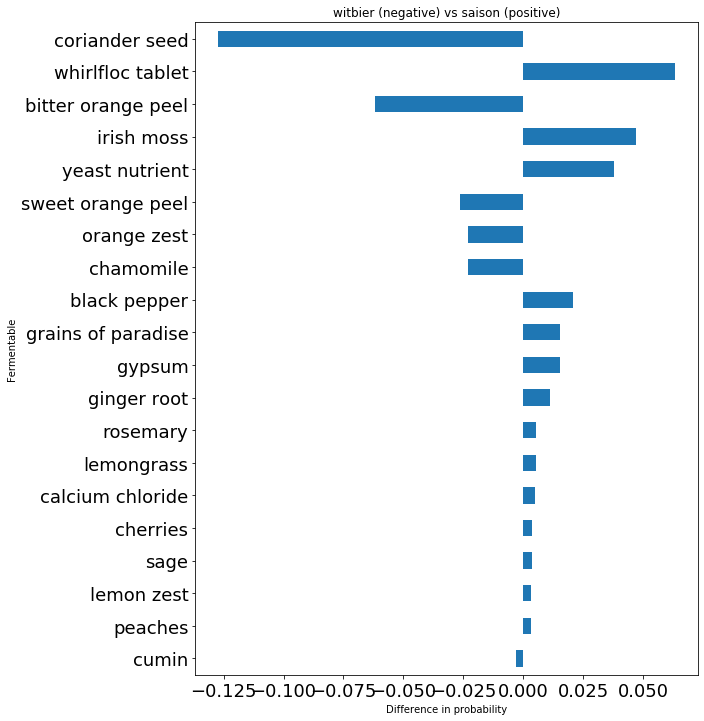

In [106]:
styles = ["witbier", "saison"]
compare_style_ferm_probabilities(styles, "misc")

# Adjust for Mass

The above calculation simply adds "1" for each appearance of a fermentable, regardless of how much of the fermentable is added, and would add multiple if it appeared in the recipe multiple times. What would likely be better would be to look at the percentage of the grain bill for each fermentable.

There are two approaches to messuring "percentage of the grain bill" each fermentable makes up in a recipe:
* Percentage of the total mass of fermentable
* Mass per litre (of either batch size or boil size) of the fermentable

The first one, percentage of the total mass, is more itneresting, because it prevents stronger beers from dominating the average over many recipes

### Consider the percentage of the total mass of the "sum of all recipes" of each style

In [43]:
by_style_ferm = stouts.groupby(["style_name", "ferm_name"]).ferm_amount.sum()
by_style = stouts.groupby(["style_name"]).ferm_amount.sum()
average_bill = by_style_ferm / by_style
average_bill

style_name      ferm_name               
american stout  2-row                       0.221514
                2-row brewers malt          0.060178
                2-row caramel malt 60l      0.004986
                6-row                       0.001385
                6-row brewers malt          0.002961
                                              ...   
robust porter   wheat malt extract syrup    0.000342
                wheat malt, white           0.001895
                wheat, flaked               0.003479
                wheat, red                  0.000065
                white wheat                 0.003947
Name: ferm_amount, Length: 361, dtype: float64

In [44]:
average_bill = average_bill.reset_index()
ferms_by_mass = average_bill.pivot_table(index="ferm_name", columns="style_name", dropna=False)
ferms_by_mass.columns = ferms_by_mass.columns.droplevel()

In [45]:
ferms_by_mass

style_name,american stout,robust porter
ferm_name,,
2-row,0.221514,0.199785
2-row brewers malt,0.060178,0.087239
2-row caramel malt 60l,0.004986,0.007060
6-row,0.001385,0.002051
6-row brewers malt,0.002961,0.008515
...,...,...
wheat malt extract syrup,0.000083,0.000342
"wheat malt, white",0.001554,0.001895
"wheat, flaked",0.000355,0.003479


In [46]:
ferms_by_mass["tot"] = ferms_by_mass.sum(axis=1)
ferms_by_mass["dif"] = ferms_by_mass["american stout"] - ferms_by_mass["robust porter"]
ferms_by_mass["absdif"] = (ferms_by_mass["american stout"] - ferms_by_mass["robust porter"]).abs()
ferms_by_mass = ferms_by_mass.sort_values("absdif")

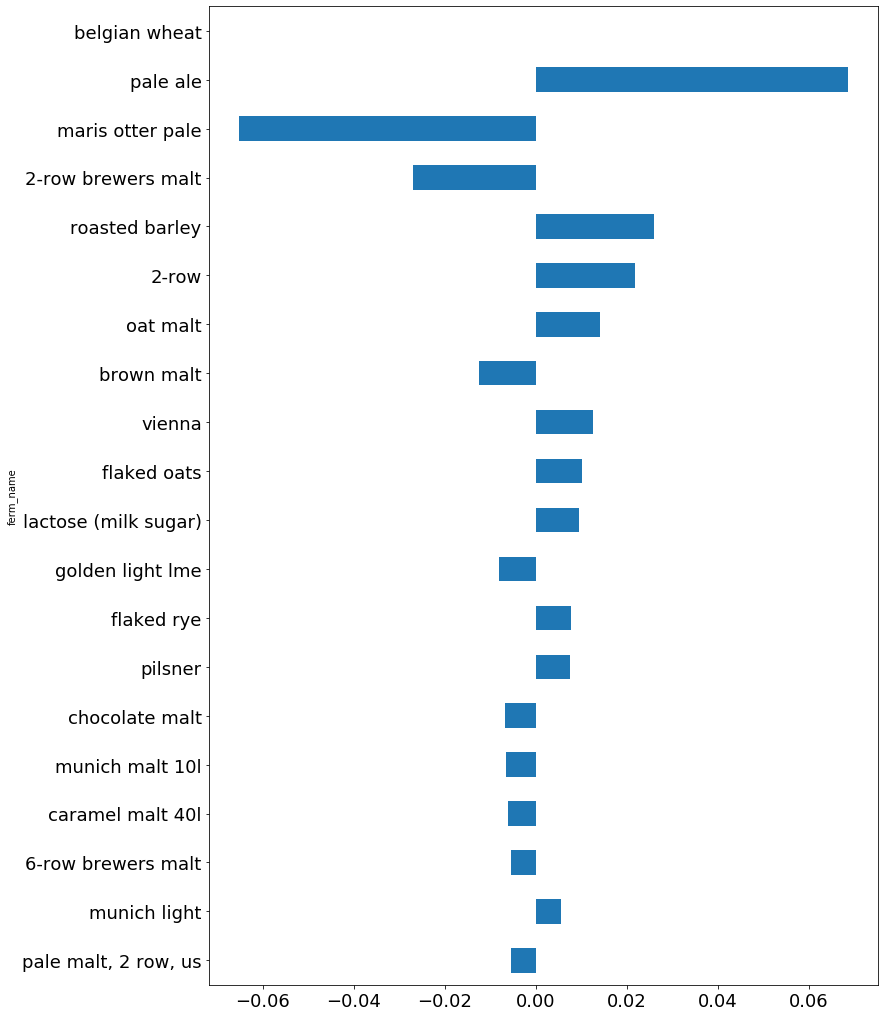

In [47]:
ferms_by_mass["dif"].iloc[-20:].plot(kind="barh", stacked=False, figsize=(12,18), fontsize=18)

### Consider the percentage of fermentable mass per recipe
Aggregation:
* Recipe
* Style

In [48]:
by_style_ferm_recipe = stouts.reset_index().groupby(["style_name", "ferm_name", "id"]).ferm_amount.sum()

In [49]:
by_style_recipe = stouts.reset_index().groupby(["style_name", "id"]).ferm_amount.sum()

In [56]:
average_bill = mean_ferm_pct_of_grain_bill * prob_ferm_by_style / average_bill.groupby("style_name").sum()["ferm_amount"]

In [57]:
average_bill = average_bill.reset_index()
ferms_by_mass = average_bill.pivot_table(index="ferm_name", columns="style_name", dropna=False)
ferms_by_mass.columns = ferms_by_mass.columns.droplevel()

In [58]:
ferms_by_mass["tot"] = ferms_by_mass.sum(axis=1)
ferms_by_mass["dif"] = ferms_by_mass["american stout"] - ferms_by_mass["robust porter"]
ferms_by_mass["absdif"] = (ferms_by_mass["american stout"] - ferms_by_mass["robust porter"]).abs()
ferms_by_mass = ferms_by_mass.sort_values("absdif", na_position="first")

Text(0.5, 0, 'Difference in probability')

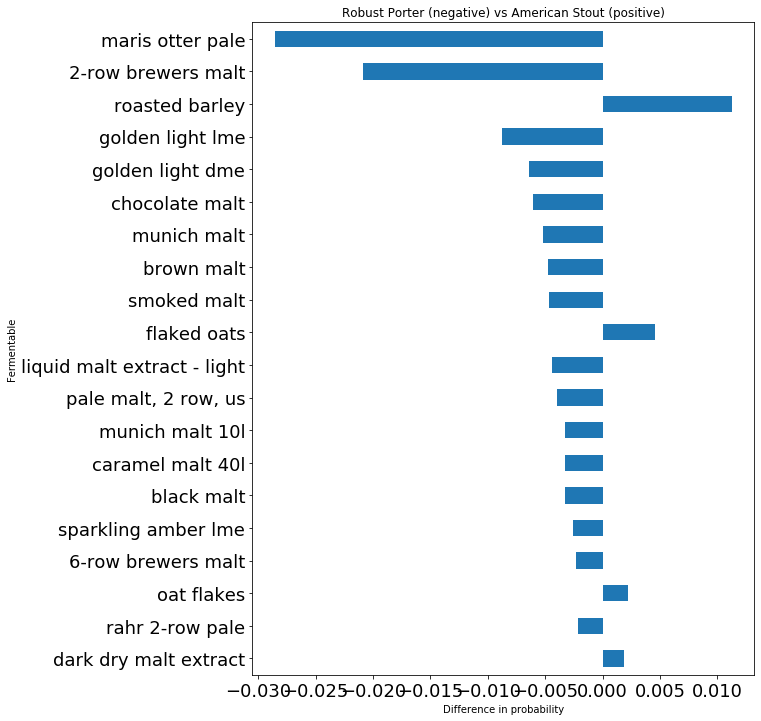

In [59]:
ax = ferms_by_mass.iloc[-20:, 3].plot(kind="barh", stacked=False, figsize=(9,12), fontsize=18)
ax.set_title("Robust Porter (negative) vs American Stout (positive)")
ax.set_ylabel("Fermentable")
ax.set_xlabel("Difference in probability")

### How many different fermentables are going into each recipe on average, per style?

Text(0, 0.5, 'Share of recipes')

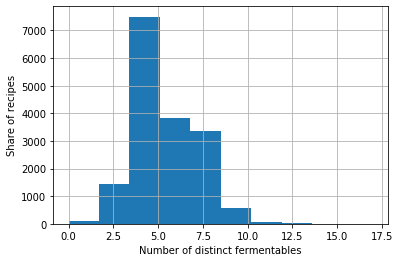

In [60]:
stouts.groupby("id").ferm_name.nunique().hist()
plt.xlabel("Number of distinct fermentables")
plt.ylabel("Share of recipes")